In [ ]:
# Mount Google Drive Folder (/content/drive/My Drive/Colab)
from google.colab import drive
drive.mount('/content/drive')

# import user defined files
import sys
import_dir ="/content/drive/My Drive/Colab Notebooks/3. Semantic Segmentation"
sys.path.insert(0, import_dir)

# import ipynb files
!pip install import_ipynb
import import_ipynb

# Import ipynb in different directory
#%run '/content/drive/My Drive/Colab Notebooks/3. Semantic Segmentation/dataset.ipynb'

# import easydict instead of using argparse (argparse is not usuable for ipynb)
import easydict
global _args
_args = easydict.EasyDict({"config": '/content/drive/My Drive/Colab Notebooks/3. Semantic Segmentation/config/isic.yaml'})

# Debugging Tool
import pdb

In [ ]:
# Download & Unzip Dataset (Move from google drive to local)
%cp -r '/content/drive/My Drive/Colab Notebooks/Dataset/ISIC/ISIC.zip' '/content/sample_data'

!unzip '/content/sample_data/ISIC.zip'

In [ ]:
# Initilize Additional parameters
train_root = "/content/ISIC_Trainset"
test_root = "/content/ISIC_Testset"

In [ ]:
import os
import pdb
import argparse
import numpy as np
import torch
import torch.nn as nn

import models
from utils import dataset, config, utils, dataset_utils # utils 폴더에 있는 모든 파일을 불러온다.

In [ ]:
def get_parser(args):
    '''
    # Removed Code (Because ipynb file does not support argparse)
    # Even removed, these lines are substitued by easydict code

    parser = argparse.ArgumentParser(description='PyTorch Semantic Segmentation')
    parser.add_argument('--config', type=str, default='config/cityscapes.yaml')
    args = parser.parse_args()
    '''
    assert args.config is not None

    cfg = config.load_cfg_from_cfg_file(args.config) # utils<config.py<load_cfg_from_cfg_file
    return cfg # 여기서 yaml파일 저장해줌.

In [ ]:
def check(args): # 예외처리 구문이다.
    assert args.data_name in ['crack', 'cityscapes', 'isic']
    assert args.classes >= 1
    assert args.model in ['unet32', 'unet64', 'unet128',
                          'deeplab34','deeplab50','deeplab101',
                          'pspnet18', 'pspnet34', 'pspnet50']
    assert args.loss in ['bce','ce','dice']

In [ ]:
def main():
    args = get_parser(_args)
    # print(args.config)
    check(args)
    os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(str(x) for x in args.gpu) # 파라미터로 넣어줌
    main_worker(args)

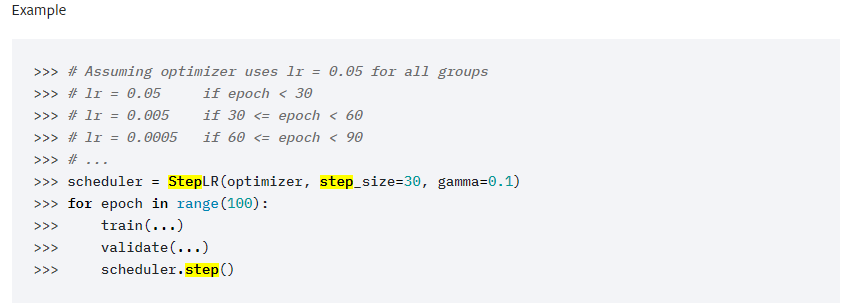

In [ ]:
def main_worker(argss):
    global args
    args = argss

    ##### Model #####

    model = models.load_model(args) 
    # 파이토치에서는 pdb로 다 찍어본다.
    optimizer = torch.optim.Adam(model.parameters(), lr=args.base_lr)
   
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # StepLR Learning Rater 를 말한다.
    #StepLR은 학습을 진행 함에 따라서 Learning Rate를 줄여주는 방법이다.
    # step_size=10, gamma=0.5 를 얼마나 주느냐에 따라서 파형이 달라진다.

    best_loss = 999.0

    if len(args.gpu) > 1:
        model = torch.nn.DataParallel(model.cuda())
    else:
        model = model.cuda()
    print(f"=> creating {args.model} (classes:{args.classes})")
   
    os.makedirs(args.ckpt_root, exist_ok=True)
 
    if args.weight: # args.resume과 같은 표현이다. 
        if os.path.isfile(args.weight):
            ckpt = torch.load(args.weight, map_location=lambda storage, loc: storage.cuda())
            args.start_epoch = ckpt['epoch']
            model.load_state_dict(ckpt['state_dict'], strict=False) # strict 를 유연하게 한다? 가장 중요한 부분이다!!
            # strict=False에 대해서 알아보자 
            optimizer.load_state_dict(ckpt['optimizer']) # 내가 지정한 optimizer에 모든 모델이 전반적으로 학습된다.
            print(f"=> loaded checkpoint '{args.weight}' (epoch {ckpt['epoch']})")
        else:
            print(f"=> no weight found at '{args.weight}'")

    ##### Data #####
    criterion, transforms, _, _, _ = dataset_utils.dataset_utils(args)

    train_loader = torch.utils.data.DataLoader(
                    dataset.Dataset(mode='train', data_root=args.train_root, data_list=args.train_list,
                                    transform=transforms[0], label_transform=transforms[3]),
                    batch_size=args.batch_size, shuffle=True, num_workers=args.workers,
                    pin_memory=True, drop_last=True)

    val_loader = torch.utils.data.DataLoader(
                    dataset.Dataset(mode='val', data_root=args.val_root, data_list=args.val_list,
                                    transform=transforms[1], label_transform=transforms[3]),
                    batch_size=args.batch_size, shuffle=False, num_workers=args.workers,
                    pin_memory=True)

    ##### Train & Validation #####
    del_ckpt = None
    for epoch in range(args.start_epoch, args.epochs):
        loss_train = train(train_loader, model, criterion,
                                        optimizer, scheduler, epoch)
        loss_val = validate(val_loader, model, criterion, epoch)

        if best_loss > loss_val:
            best_loss = loss_val
            if del_ckpt:
                os.remove(del_ckpt)
            filename = f'{args.ckpt_root}/{args.data_name}_{args.model}_{epoch+1}.pth'
            torch.save({'epoch': epoch+1,
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict()}, filename)
            del_ckpt = filename
            print(f'Saving checkpoint to: {filename}')

In [ ]:
def train(train_loader, model, criterion, optimizer, scheduler, epoch): # 이부분은 이미 알고 있는 코드이다.
    print(f'\nMode: Train | Epoch: {epoch+1}/{args.epochs} | Model: {args.model} | Data: {args.data_name}')
    loss_meter = utils.AverageMeter()

    torch.set_grad_enabled(True)
    model.train()
    for i, data in enumerate(train_loader):
        img, label = data[0].cuda(), data[1].cuda()
        output = model(img)
        loss = criterion(output, label.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item(), img.size(0))
        # utils.progress_bar(i, len(train_loader), f'Loss:{loss_meter.avg:.4f}')
    print(f'Loss:{loss_meter.avg:.4f}')
    scheduler.step()
    torch.cuda.empty_cache()
    return loss_meter.avg

In [ ]:
def validate(val_loader, model, criterion, epoch):
    print(f'\nMode: Validation  |  Epoch: {epoch+1}/{args.epochs}  |  Model: {args.model}')
    loss_meter = utils.AverageMeter()

    torch.set_grad_enabled(False)
    model.eval()
    for i, data in enumerate(val_loader):
        img, label = data[0].cuda(), data[1].cuda()
        output = model(img)
        loss = criterion(output, label.long())
        loss_meter.update(loss.item(), img.size(0))
        # utils.progress_bar(i, len(val_loader), f'Loss:{loss_meter.avg:.4f}')
    print(f'Loss:{loss_meter.avg:.4f}')
    torch.cuda.empty_cache()
    return loss_meter.avg

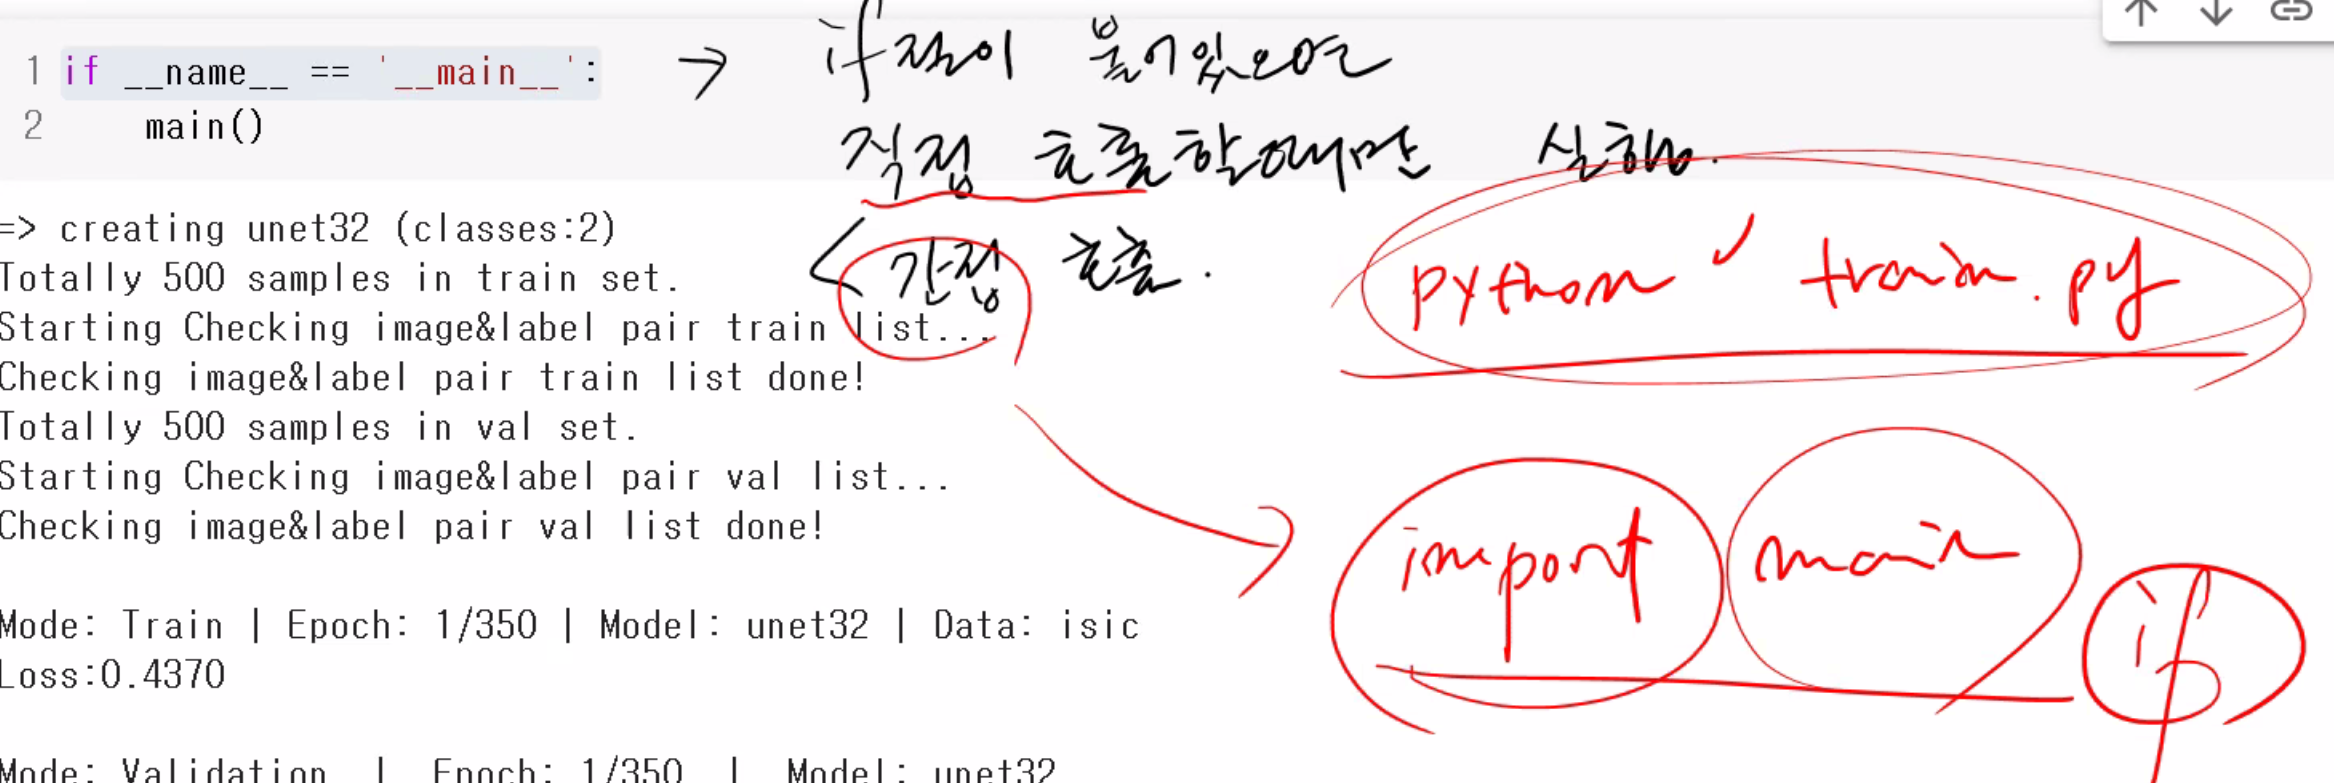

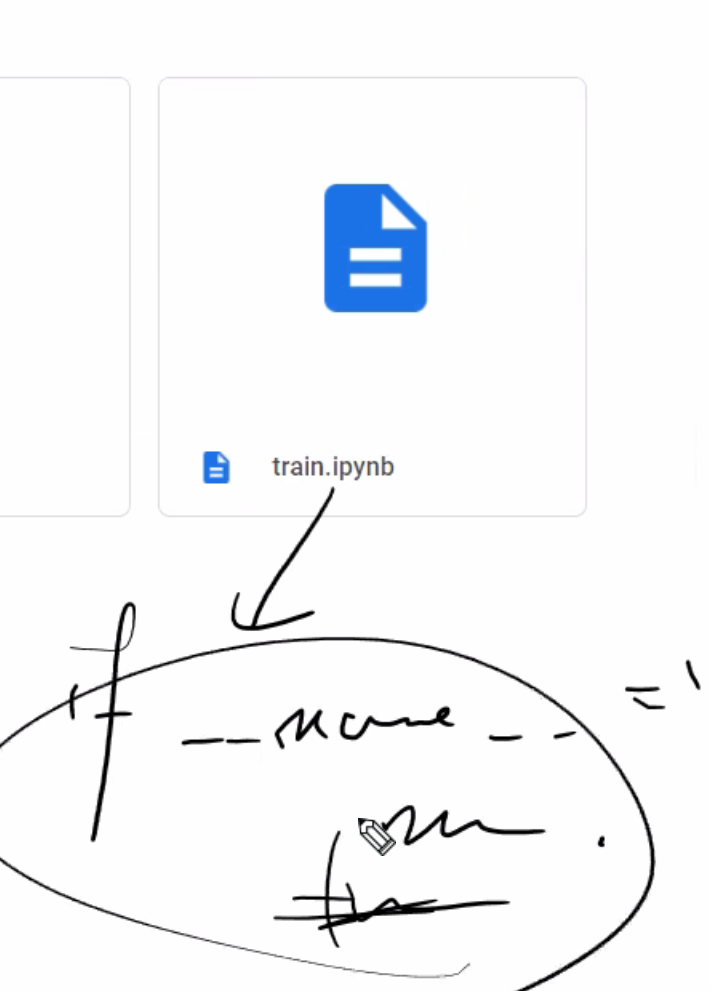

직접호출 시키는 구문이다.

In [ ]:
# 직접 호출시키는 건 if문을 쓰느냐 안 쓰느냐에 따라서 상황이 달라진다.
# if문을 사용해서 호출하면 간접호출이다.
# if문을 사용해서 import를 해서 사용한 경우 직접호출이다
if __name__ == '__main__': # if절이 붙어 있으면 직접 호출 할때만 실행한다. 간접호출은 import를 붙여서 사용한다.
    main()

In [ ]:
while 1:
  continue